In [1]:
"""
Análise de dados de resistência à compressão do concreto.

Objetivos:
- Explorar correlações entre variáveis numéricas.
- Visualizar relações entre atributos e resistência.
- Avaliar performance de modelos de regressão (Random Forest e Linear).
- Interpretar variáveis mais relevantes via SHAP.

Etapas: Carregamento → Limpeza → Exploração → Engenharia → Modelagem → Interpretação.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [30]:
def carregar_dados(caminho_csv: str) -> pd.DataFrame:
    """Carrega os dados do CSV"""
    df = pd.read_csv(caminho_csv)
    return df.dropna()

In [31]:
df = carregar_dados('dados_concreto.csv')
df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength,Strength Category
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99,Alto
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89,Alto
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27,Baixa
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05,Baixa
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30,Baixa
...,...,...,...,...,...,...,...,...,...,...
2023,607.2,237.8,0.0,448.4,17.4,1701.5,1156.0,78.4,33.40,Baixa
2024,449.2,0.0,0.0,323.3,17.4,2229.0,1314.7,30.8,39.10,Baixa
2026,183.1,310.3,0.0,380.0,17.0,2604.7,1299.4,30.8,24.20,Baixa
2027,651.0,399.8,0.0,386.2,19.0,2102.9,1125.6,72.8,40.80,Baixa


In [32]:
def plot_matriz_correlacao(df: pd.DataFrame) -> None:
    """Plota a matriz de correlação das variáveis numéricas."""
    corr = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Mapa de Calor das Correlações entre Variáveis')
    plt.tight_layout()
    plt.show()

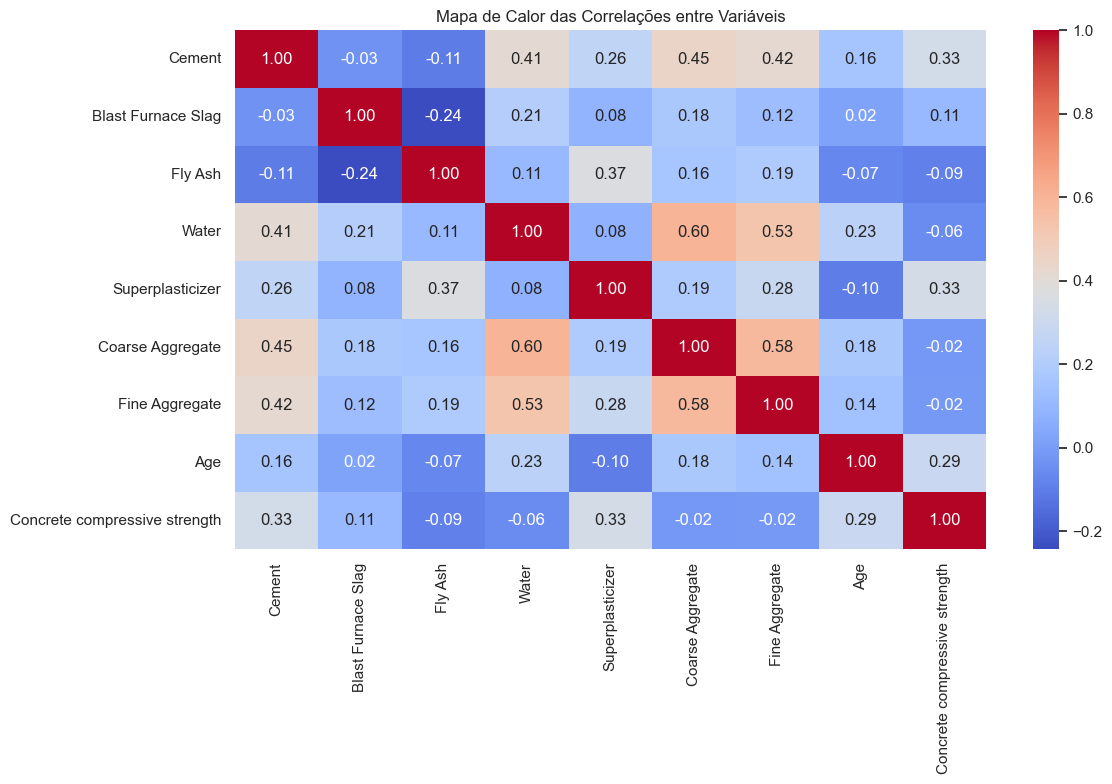

In [33]:
plot_matriz_correlacao(df)

In [34]:
def plot_dispersao_variaveis(df: pd.DataFrame) -> None:
    """Plota a relação entre variáveis e resistência à compressão."""
    variaveis = ['Cement', 'Water', 'Age']
    for var in variaveis:
        plt.figure()
        sns.scatterplot(data=df, x=var, y='Concrete compressive strength', hue='Strength Category')
        plt.title(f'Relação entre {var} e Concrete compressive strength')
        plt.xlabel(var)
        plt.ylabel('Concrete compressive strength')
        plt.legend(title='Strength Category', loc='best')
        plt.tight_layout()
        plt.show()

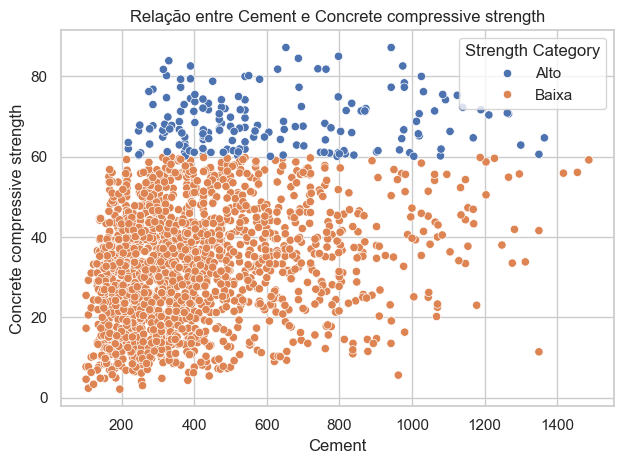

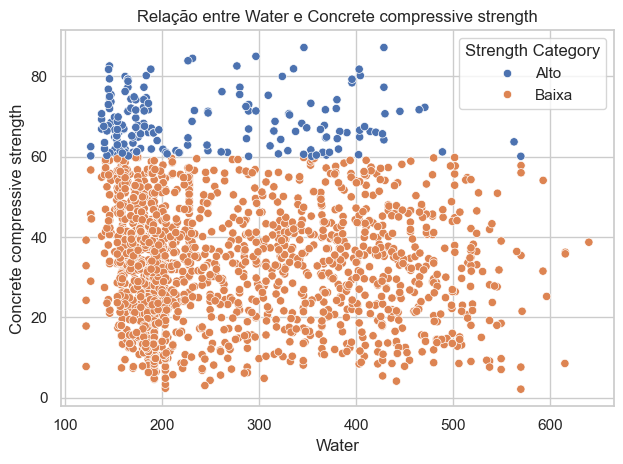

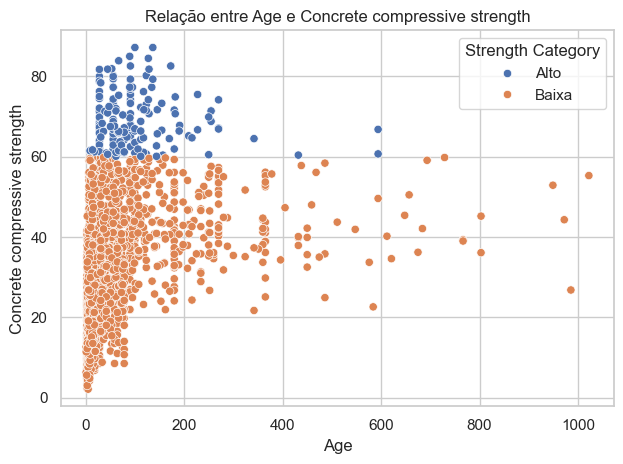

In [35]:
plot_dispersao_variaveis(df)

In [36]:
def plot_resistencia_media(df: pd.DataFrame) -> None:
    """Plota a média da resistência por categoria de força."""
    media_resistencia = df.groupby('Strength Category')['Concrete compressive strength'].mean().reset_index()
    sns.set_theme(style = 'whitegrid')
    plt.figure(figsize=(6, 4))
    plt.barh(media_resistencia['Strength Category'], media_resistencia['Concrete compressive strength'],
             color='steelblue')
    plt.title('Média da Resistência à Compressão por Força do Concreto')
    plt.xlabel('Resistência à Compressão Média')
    plt.ylabel('Força do Concreto')
    plt.tight_layout()
    plt.show()

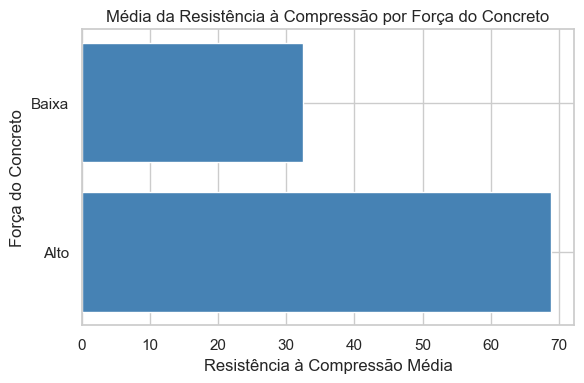

In [37]:
plot_resistencia_media(df)

In [38]:
def preparar_variaveis(df: pd.DataFrame) -> pd.DataFrame:
    """Cria variáveis dummies e renomeia colunas."""
    df_dummies = pd.get_dummies(df['Strength Category'], prefix = 'Strength', prefix_sep = '_', dtype=int, drop_first=True)
    df_resultado = pd.concat([df, df_dummies], axis=1).drop(columns = ['Strength Category'])
    df_resultado.columns = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age',
       'Concrete compressive strength', 'is_Strength']
    return df_resultado

In [39]:
df = preparar_variaveis(df)

In [40]:
def treinar_modelos(X_train, X_test, y_train, y_test):
    """Treina RandomForest e Regressão Linear e exibe métricas."""
    
    # Random Forest
    modelo_rf = RandomForestRegressor(random_state=42)
    modelo_rf.fit(X_train, y_train)
    y_pred_rf = modelo_rf.predict(X_test)
    print('[Random Forest]')
    print('R²:', r2_score(y_test, y_pred_rf))
    print('MAE:', mean_absolute_error(y_test, y_pred_rf))

    # Regressão Linear
    modelo_lr = LinearRegression()
    modelo_lr.fit(X_train, y_train)
    y_pred_lr = modelo_lr.predict(X_test)
    print('\n[Regressão Linear]')
    print('R²:', r2_score(y_test, y_pred_lr))
    print('MAE:', mean_absolute_error(y_test, y_pred_lr))

    return modelo_rf, modelo_lr

In [41]:
X = df.drop(['Concrete compressive strength', 'is_Strength'], axis = 1)
y = df['Concrete compressive strength']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [43]:
modelo_rf, modelo_lr = treinar_modelos(X_train, X_test, y_train, y_test)

[Random Forest]
R²: 0.7807434294533199
MAE: 5.422982326143328

[Regressão Linear]
R²: 0.37309734536090233
MAE: 10.366095631758803


In [54]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    # 'min_samples_leaf': [2, 4],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 0.5],
    'bootstrap': [True]
}

grid_model = GridSearchCV(modelo_rf, params, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 0.5],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

In [46]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:, ~df_cv_results.columns.str.contains('split | time')].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,
1,2.560387,0.083718,0.047516,0.004200,True,20,0.5,2,5,300,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.773199,0.811785,0.808599,0.748660,0.729656,0.774380,0.032352
2,0.817972,0.017187,0.017222,0.001357,True,15,0.5,2,5,100,"{'bootstrap': True, 'max_depth': 15, 'max_feat...",0.772038,0.807807,0.807224,0.752571,0.730456,0.774019,0.030351
3,1.625810,0.028002,0.029599,0.002154,True,20,0.5,2,5,200,"{'bootstrap': True, 'max_depth': 20, 'max_feat...",0.772306,0.809714,0.807240,0.750730,0.729887,0.773975,0.031211
4,1.616117,0.023797,0.028792,0.001172,True,15,0.5,2,5,200,"{'bootstrap': True, 'max_depth': 15, 'max_feat...",0.773382,0.810366,0.805647,0.747937,0.731260,0.773719,0.031081
5,2.414493,0.024644,0.044641,0.001844,True,15,0.5,2,5,300,"{'bootstrap': True, 'max_depth': 15, 'max_feat...",0.772782,0.812261,0.805474,0.747099,0.729021,0.773328,0.032250


In [47]:
model = grid_model.best_estimator_

In [48]:
y_pred_grid = model.predict(X_test)
print('R²:', r2_score(y_test, y_pred_grid))
print('MAE:', mean_absolute_error(y_test, y_pred_grid))

R²: 0.78816144096865
MAE: 5.5073148041806235


<Axes: xlabel='Concrete compressive strength'>

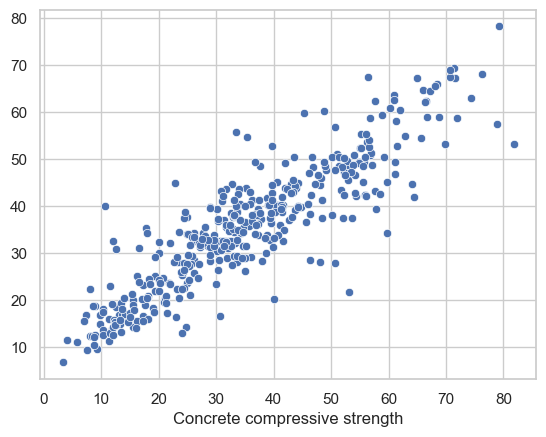

In [49]:
sns.scatterplot(x = y_test, y = y_pred_grid)

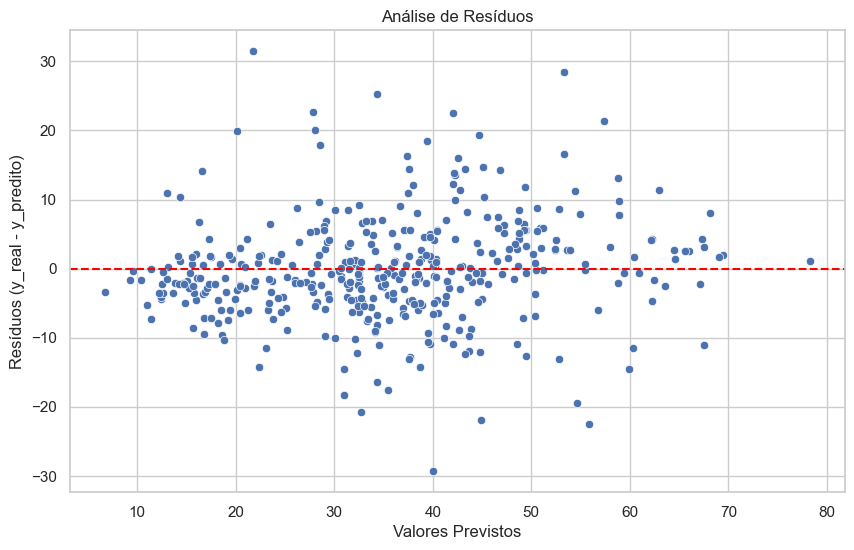

In [50]:
residuo = y_test - y_pred_grid

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_grid, y=residuo)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos (y_real - y_predito)')
plt.title('Análise de Resíduos')
plt.grid(True)
plt.show()

In [51]:
def interpretar_modelo(modelo, X_test):
    """Plota o resumo SHAP para interpretação do modelo."""
    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


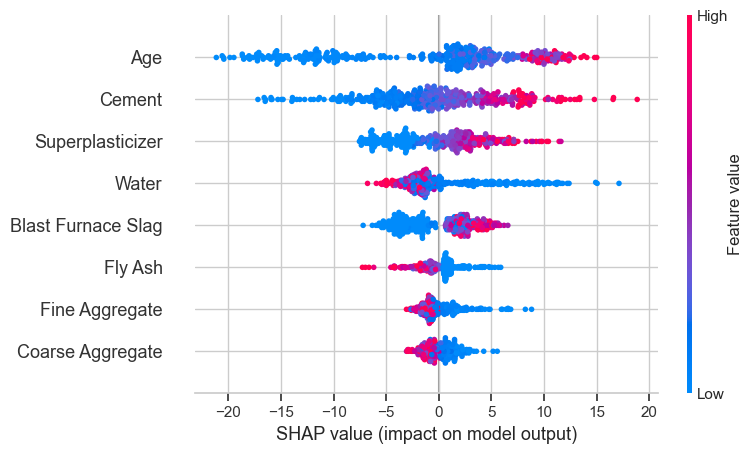

In [52]:
interpretar_modelo(modelo_rf, X_test)

In [124]:
novos_dados = pd.DataFrame([{
    'Cement': 800,
    'Blast Furnace Slag': 190,
    'Fly Ash': 0,
    'Water': 150,
    'Superplasticizer': 3.5,
    'Coarse Aggregate': 1000,
    'Fine Aggregate': 700,
    'Age': 500
}])

pred_rf = modelo_rf.predict(novos_dados)
print(pred_rf)

[70.1853]
